<a href="https://colab.research.google.com/github/Viktoriya89/doc_tex_source/blob/main/Caltech101_module4_VSergeyeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet Deep Image du module 4, en ré-utilisant le TP vu en cours.

In [79]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn

Mounted at /content/drive


In [80]:
# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm
#from tqdm import tqdm_notebook as tqdm

#matpotlib 
#import matplotlib
import matplotlib.pyplot as plt

# Modules (torch, nn, F et optim)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Chargement des images  Caltech101, environ 10000 images 300X200 pixels. Les objets sont rangés selon 101 catégories. 
http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

Documentation pour ImageFolder: https://pytorch.org/vision/stable/datasets.html#imagefolder

D'abord, je charge le dataset total, avec son loader et je visualise une image pour verifier que les images sont bien chargées.

Dimension d'un mini-batch de loader:  torch.Size([32, 3, 32, 32])
 img.size() =  torch.Size([3, 32, 32])
 img.dim() =  3
 img.size()[0] =  3


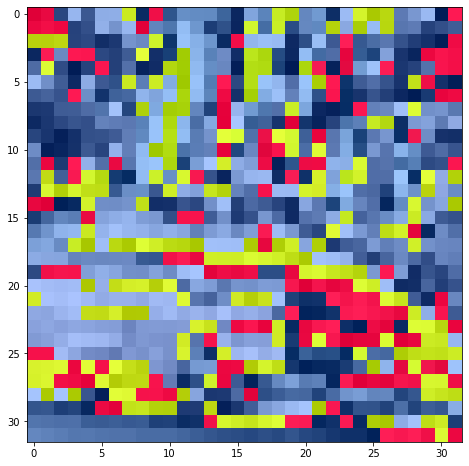

In [82]:
batchsize=32
image_size = 224

# Transformations à appliquer pour l'ensemble d'apprentissage
transformTrain = transforms.Compose(
    [transforms.Resize((image_size, image_size)),
     transforms.ToTensor(),
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(), 
     transforms.RandomResizedCrop(32),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ])

train_dataset = datasets.ImageFolder('drive/MyDrive/data/101_ObjectCategories', transform=transformTrain)
loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, pin_memory=True, shuffle=True)

# Recuperation du premier batch
images,labs=iter(loader).next()

print("Dimension d'un mini-batch de loader: ", images.size())
img = images[0]
print(" img.size() = ", img.size())
print(" img.dim() = ", img.dim())
print(" img.size()[0] = ", img.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
tr = transforms.ToPILImage()
img0 = tr(img)
plt.imshow(np.array(img0))

Maintenant, je veux créer les ensembles d'apprentissage (train) et de validation (test), avec une proportion 90%:10%. Nous avons 8683 images en total.

 length raw dataset =  8683
 split =  868
 Train length =  7815
 Test length =  868
 Train size:  7815
Dimension d'un mini-batch de train_loader:  torch.Size([32, 3, 32, 32])
 img_bx.size() =  torch.Size([3, 32, 32])
 img_bx.dim() =  3
 img_bx.size()[0] =  3


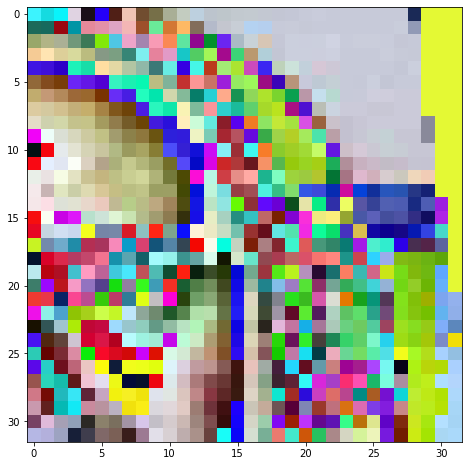

In [83]:
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler

proportion = 0.1

num_raw = len(train_dataset)
indices = list(range(num_raw))
split = int(np.floor(proportion * num_raw)) # 10% pour l'ensemble de validation

print(" length raw dataset = ", num_raw)
#print(" indices: ", indices)
print(" split = ", split)

# On melange les indices des images
#np.random.seed(13)
np.random.shuffle(indices)
#print(" indices: ", indices)

# division en 2 ensembles, l'indice = split est la frontiere entre train et test
train_indices =  indices[split:]
print(" Train length = ", len(train_indices))
test_indices = indices[:split]
print(" Test length = ", len(test_indices))

train_subset = Subset(train_dataset, train_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batchsize, pin_memory=True, shuffle=True)

train_size = len(train_subset)
print(" Train size: ", train_size)

# Recuperation du premier batch
bx, by = iter(trainloader).next()
print("Dimension d'un mini-batch de train_loader: ", bx.size())
img_bx = bx[0]
print(" img_bx.size() = ", img_bx.size())
print(" img_bx.dim() = ", img_bx.dim())
print(" img_bx.size()[0] = ", img_bx.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
img1 = tr(img_bx)
plt.imshow(np.array(img1))

Je crée un bloque "transform" different pour le "test", avec uniquement la normalisation, resize et la transformation vers le tenseur.

 Test size:  868
Dimension d'un mini-batch de test_loader:  torch.Size([32, 3, 224, 224])
 img_bx.size() =  torch.Size([3, 224, 224])
 img_bx.dim() =  3
 img_bx.size()[0] =  3


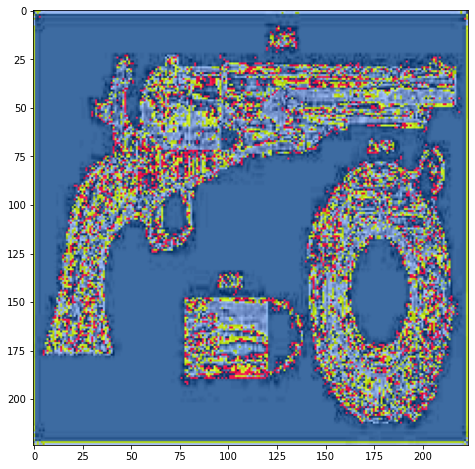

In [84]:
# Pour l'ensemble de validation   
transformTest = transforms.Compose(
    [transforms.Resize((image_size, image_size)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# on charge avec la transformations differentes pour le test
test_dataset = datasets.ImageFolder('drive/MyDrive/data/101_ObjectCategories', transform=transformTest)

# on refait la même procedure que avant pour créer le loader avec les indices des images
test_subset = Subset(test_dataset, test_indices)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batchsize, pin_memory=True, shuffle=True)

test_size = len(test_subset)
print(" Test size: ", test_size)

# Recuperation du premier batch
bx, by = iter(testloader).next()
print("Dimension d'un mini-batch de test_loader: ", bx.size())
img_bx = bx[0]
print(" img_bx.size() = ", img_bx.size())
print(" img_bx.dim() = ", img_bx.dim())
print(" img_bx.size()[0] = ", img_bx.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
img1 = tr(img_bx)
plt.imshow(np.array(img1))

Les données sont maintenant separées en "train" et "test", les images sont chargées par mini-batchs de 32, avec trainloader et testloader.

Partie 2: utilisation des modèles pré-entrainés. Importation de 6 modèles. 

In [6]:
from torchvision import models
net = models.resnet18(pretrained=True)
print(net)
# Derniere couche:
# (fc): Linear(in_features=512, out_features=1000, bias=True)

net2 = models.alexnet(pretrained=True)
#print(net2)
# Derniere couche:
# (6): Linear(in_features=4096, out_features=1000, bias=True)

net3 = models.squeezenet1_0(pretrained=True)
#print(net3)
# Derniere couche:
# (3): AdaptiveAvgPool2d(output_size=(1, 1))

net4 = models.vgg16(pretrained=True)
#print(net4)
# Derniere couche:
# (6): Linear(in_features=4096, out_features=1000, bias=True)

net5 = models.densenet161(pretrained=True)
#print(net5)
# Derniere couche:
# (classifier): Linear(in_features=2208, out_features=1000, bias=True)

net6 = models.inception_v3(pretrained=True)
#print(net6)
# Derniere couche:
# (fc): Linear(in_features=2048, out_features=1000, bias=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [7]:
def set_parameter_requires_grad(requires_grad=True):
    for param in net.parameters():
        param.requires_grad = requires_grad

my_num_classes = 101

def train(nbEpochs=2):
    print(net)
    
    criterion = nn.CrossEntropyLoss()
    for epoch in range(nbEpochs):  
        tloss = 0.0
        i=0
        t = tqdm(iter(trainloader), total=len(trainloader), dynamic_ncols=True)
        for data in t:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            tloss += loss.item()
        
        tloss=tloss/len(trainloader)
        #tbw.add_scalar("loss/train", tloss, epoch)
        print("train loss=",epoch, tloss) 
        
        tloss=0.0
        ok = 0
        tot = 0
        with torch.no_grad():
            t = tqdm(iter(testloader), total=len(testloader))
            for data in t:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                tot += labels.size(0)
                ok += (predicted == labels).sum().item()
                tloss += loss.item()
        
        tloss=tloss/len(testloader)
        #tbw.add_scalar("loss/test", tloss, epoch)
        print("test loss=",epoch, tloss) 
               
        print('Accuracy in test', (100.0 * ok / tot))

Je commence d'abord par resnet18.

In [8]:
# Fixons d'abord les poids du réseau :
set_parameter_requires_grad(False)

# Pour avoir 101 classes et non 1000 en sortie :
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, my_num_classes)

#print(net1)
# Derniere couche
# (fc): Linear(in_features=512, out_features=101, bias=True)

In [9]:
net.to(device)
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
            
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
train(3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

NameError: ignored